In [1]:
!pip install torchinfo

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import kagglehub
import os
import torch.nn as nn
import torchvision.models as models
import wandb
import gc
from torchinfo import summary
from torch import optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore")

In [21]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {'values': [0.001,0.0001]},
        'batch_size': {'values': [16, 64]},
        'num_epochs': {'values': [10, 20]}
    }
}
sweep_id = wandb.sweep(sweep_config, project='googleNet_5_flower')

Create sweep with ID: xn70ahcq
Sweep URL: https://wandb.ai/pro-laxmi-indian-institute-of-technology-gandhinagar/googleNet_5_flower/sweeps/xn70ahcq


In [ ]:
def train():
    with wandb.init() as run:
        config = wandb.config

        learning_rate = config.learning_rate
        batch_size = config.batch_size
        num_epochs = config.num_epochs

        # Data Transformations
        path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
        
        image_size = 227
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        dataset_path = os.path.join(path, "flowers")
        dataset = ImageFolder(root=dataset_path, transform=transform)

        train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
        train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

        # Model declaration
        class GoogleNet(nn.Module):
            def __init__(self, num_classes=5):
                super().__init__()
                self.base_model = models.googlenet(weights=models.GoogLeNet_Weights)
                # Freeze the feature layers
                for param in self.parameters():
                    param.requires_grad = False
                # Change the classifier layer
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(1000, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(),

                    nn.Linear(4096, 4096),
                    nn.ReLU(inplace=True), 
                    nn.Dropout(),

                    nn.Linear(4096, num_classes)
                )
            def forward(self, x):
                x = self.base_model(x)
                x = self.classifier(x)
                return x

        # Transferring on GPU for better results
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = GoogleNet().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_values = []
        training_accuracy = []
        validation_accuracy = []

        # Training loop
        for epoch in range(num_epochs):
            # --- TRAINING PHASE ---
            model.train()  # Set model to training mode
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            
            for images, labels in train_dataset:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            avg_loss = running_loss / len(train_dataset)
            train_acc = correct_train / total_train
            
            loss_values.append(avg_loss)
            training_accuracy.append(train_acc)
            
            # --- VALIDATION PHASE ---
            model.eval()
            correct_val = 0
            total_val = 0
            
            with torch.no_grad():
                for images, labels in val_dataset:
                    images, labels = images.to(device), labels.to(device)
                    
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    
            val_acc = correct_val / total_val
            validation_accuracy.append(val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
            wandb.log({
                'epoch': epoch+1,
                'loss': avg_loss,
                'training_accuracy': train_acc,
                'validation_accuracy': val_acc
            })
        # Final evaluation on test data
        model.eval()
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_dataset:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
        test_acc = correct_test / total_test
        print(f"Test Accuracy: {test_acc:.4f}")
        wandb.log({'test_accuracy': test_acc})
        del model, optimizer, criterion, images, labels, outputs
        gc.collect()
        torch.cuda.empty_cache()
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: bs99r5qk with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: Currently logged in as: pro-laxmi (pro-laxmi-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/10], Loss: 1.0174, Training Accuracy: 0.7163, Validation Accuracy: 0.8121
Epoch [2/10], Loss: 0.6810, Training Accuracy: 0.7771, Validation Accuracy: 0.8585
Epoch [3/10], Loss: 0.6220, Training Accuracy: 0.8063, Validation Accuracy: 0.8492
Epoch [4/10], Loss: 0.6435, Training Accuracy: 0.7973, Validation Accuracy: 0.8144
Epoch [5/10], Loss: 0.6223, Training Accuracy: 0.8086, Validation Accuracy: 0.8515
Epoch [6/10], Loss: 0.5999, Training Accuracy: 0.8234, Validation Accuracy: 0.8469
Epoch [7/10], Loss: 0.5675, Training Accuracy: 0.8237, Validation Accuracy: 0.8492
Epoch [8/10], Loss: 0.5946, Training Accuracy: 0.8289, Validation Accuracy: 0.8654
Epoch [9/10], Loss: 0.6155, Training Accuracy: 0.8272, Validation Accuracy: 0.8654
Epoch [10/10], Loss: 0.6058, Training Accuracy: 0.8277, Validation Accuracy: 0.8445
Test Accuracy: 0.8681


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▂▂
test_accuracy,▁
training_accuracy,▁▅▇▆▇█████
validation_accuracy,▁▇▆▁▆▆▆██▅
epoch,10
loss,0.60576
test_accuracy,0.86806
training_accuracy,0.82774
validation_accuracy,0.84455


wandb: Agent Starting Run: tjh05nce with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 20


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/20], Loss: 0.9520, Training Accuracy: 0.7197, Validation Accuracy: 0.8469
Epoch [2/20], Loss: 0.6912, Training Accuracy: 0.7782, Validation Accuracy: 0.8701
Epoch [3/20], Loss: 0.6660, Training Accuracy: 0.7942, Validation Accuracy: 0.8747
Epoch [4/20], Loss: 0.6070, Training Accuracy: 0.8107, Validation Accuracy: 0.8979
Epoch [5/20], Loss: 0.6042, Training Accuracy: 0.8115, Validation Accuracy: 0.8840
Epoch [6/20], Loss: 0.6014, Training Accuracy: 0.8170, Validation Accuracy: 0.8654
Epoch [7/20], Loss: 0.5766, Training Accuracy: 0.8179, Validation Accuracy: 0.8910
Epoch [8/20], Loss: 0.5680, Training Accuracy: 0.8237, Validation Accuracy: 0.8840
Epoch [9/20], Loss: 0.5599, Training Accuracy: 0.8277, Validation Accuracy: 0.8956
Epoch [10/20], Loss: 0.6067, Training Accuracy: 0.8205, Validation Accuracy: 0.8863
Epoch [11/20], Loss: 0.5496, Training Accuracy: 0.8437, Validation Accuracy: 0.8863
Epoch [12/2

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▃▂▂▂▁▁▁▂▂▁▁
test_accuracy,▁
training_accuracy,▁▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇█▇
validation_accuracy,▁▄▄▇▅▃▆▅▆▅▅▅▂▇▆▆▇▅▆█
epoch,20
loss,0.53282
test_accuracy,0.87731
training_accuracy,0.85032
validation_accuracy,0.90951


wandb: Agent Starting Run: uq8fom3v with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/10], Loss: 0.6880, Training Accuracy: 0.7496, Validation Accuracy: 0.8538
Epoch [2/10], Loss: 0.4982, Training Accuracy: 0.8243, Validation Accuracy: 0.8469
Epoch [3/10], Loss: 0.4449, Training Accuracy: 0.8405, Validation Accuracy: 0.8445
Epoch [4/10], Loss: 0.3800, Training Accuracy: 0.8642, Validation Accuracy: 0.8631
Epoch [5/10], Loss: 0.3762, Training Accuracy: 0.8610, Validation Accuracy: 0.8561
Epoch [6/10], Loss: 0.3372, Training Accuracy: 0.8772, Validation Accuracy: 0.8770
Epoch [7/10], Loss: 0.3143, Training Accuracy: 0.8842, Validation Accuracy: 0.8770
Epoch [8/10], Loss: 0.3015, Training Accuracy: 0.8877, Validation Accuracy: 0.8817
Epoch [9/10], Loss: 0.2743, Training Accuracy: 0.9007, Validation Accuracy: 0.8677
Epoch [10/10], Loss: 0.2626, Training Accuracy: 0.9074, Validation Accuracy: 0.8770
Test Accuracy: 0.8796


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
test_accuracy,▁
training_accuracy,▁▄▅▆▆▇▇▇██
validation_accuracy,▃▁▁▅▃▇▇█▅▇
epoch,10
loss,0.26261
test_accuracy,0.87963
training_accuracy,0.90735
validation_accuracy,0.87703


wandb: Agent Starting Run: z38af6v2 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 20


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/20], Loss: 0.6991, Training Accuracy: 0.7487, Validation Accuracy: 0.8747
Epoch [2/20], Loss: 0.5125, Training Accuracy: 0.8188, Validation Accuracy: 0.8747
Epoch [3/20], Loss: 0.4293, Training Accuracy: 0.8451, Validation Accuracy: 0.8747
Epoch [4/20], Loss: 0.4286, Training Accuracy: 0.8486, Validation Accuracy: 0.8886
Epoch [5/20], Loss: 0.3626, Training Accuracy: 0.8703, Validation Accuracy: 0.8863
Epoch [6/20], Loss: 0.3499, Training Accuracy: 0.8715, Validation Accuracy: 0.8840
Epoch [7/20], Loss: 0.3200, Training Accuracy: 0.8807, Validation Accuracy: 0.8654
Epoch [8/20], Loss: 0.3035, Training Accuracy: 0.8859, Validation Accuracy: 0.8817
Epoch [9/20], Loss: 0.3006, Training Accuracy: 0.8868, Validation Accuracy: 0.8840
Epoch [10/20], Loss: 0.2729, Training Accuracy: 0.9027, Validation Accuracy: 0.8956
Epoch [11/20], Loss: 0.2493, Training Accuracy: 0.9137, Validation Accuracy: 0.8840
Epoch [12/2

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▃▃▃▂▂▂▂▁▂▁▁▁▁▁
test_accuracy,▁
training_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇█▇█████
validation_accuracy,▃▃▃▆▅▅▁▅▅█▅█▃▅▇▆▅▆▅▃
epoch,20
loss,0.18922
test_accuracy,0.89583
training_accuracy,0.9337
validation_accuracy,0.87703


wandb: Agent Starting Run: of2xgzt5 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/10], Loss: 0.8291, Training Accuracy: 0.7383, Validation Accuracy: 0.8747
Epoch [2/10], Loss: 0.4185, Training Accuracy: 0.8570, Validation Accuracy: 0.8353
Epoch [3/10], Loss: 0.3976, Training Accuracy: 0.8660, Validation Accuracy: 0.8956
Epoch [4/10], Loss: 0.3524, Training Accuracy: 0.8862, Validation Accuracy: 0.8608
Epoch [5/10], Loss: 0.3197, Training Accuracy: 0.8897, Validation Accuracy: 0.8817
Epoch [6/10], Loss: 0.3081, Training Accuracy: 0.8995, Validation Accuracy: 0.8840
Epoch [7/10], Loss: 0.2941, Training Accuracy: 0.9047, Validation Accuracy: 0.8747
Epoch [8/10], Loss: 0.2726, Training Accuracy: 0.9108, Validation Accuracy: 0.8747
Epoch [9/10], Loss: 0.2714, Training Accuracy: 0.9137, Validation Accuracy: 0.8701
Epoch [10/10], Loss: 0.2571, Training Accuracy: 0.9146, Validation Accuracy: 0.8677
Test Accuracy: 0.8426


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▁▁▁▁
test_accuracy,▁
training_accuracy,▁▆▆▇▇▇████
validation_accuracy,▆▁█▄▆▇▆▆▅▅
epoch,10
loss,0.25712
test_accuracy,0.84259
training_accuracy,0.91459
validation_accuracy,0.86775


wandb: Agent Starting Run: mm4bqk1y with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 20


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/20], Loss: 0.8158, Training Accuracy: 0.7429, Validation Accuracy: 0.8306
Epoch [2/20], Loss: 0.4291, Training Accuracy: 0.8503, Validation Accuracy: 0.8538
Epoch [3/20], Loss: 0.4074, Training Accuracy: 0.8578, Validation Accuracy: 0.8469
Epoch [4/20], Loss: 0.3320, Training Accuracy: 0.8885, Validation Accuracy: 0.8353
Epoch [5/20], Loss: 0.2935, Training Accuracy: 0.8935, Validation Accuracy: 0.8492
Epoch [6/20], Loss: 0.3281, Training Accuracy: 0.8900, Validation Accuracy: 0.8376
Epoch [7/20], Loss: 0.2592, Training Accuracy: 0.9088, Validation Accuracy: 0.8585
Epoch [8/20], Loss: 0.3211, Training Accuracy: 0.8978, Validation Accuracy: 0.8585
Epoch [9/20], Loss: 0.2391, Training Accuracy: 0.9233, Validation Accuracy: 0.8469
Epoch [10/20], Loss: 0.2615, Training Accuracy: 0.9204, Validation Accuracy: 0.8515
Epoch [11/20], Loss: 0.2274, Training Accuracy: 0.9279, Validation Accuracy: 0.8654
Epoch [12/2

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▃▂▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
training_accuracy,▁▅▅▆▆▆▇▆▇▇▇▇▇▇█▇██▇█
validation_accuracy,▂▅▄▂▄▃▅▅▄▅▆▅▁▅▇▇██▇▇
epoch,20
loss,0.18022
test_accuracy,0.88194
training_accuracy,0.95368
validation_accuracy,0.87239


wandb: Agent Starting Run: o2ptpto7 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/10], Loss: 0.7225, Training Accuracy: 0.7374, Validation Accuracy: 0.8399
Epoch [2/10], Loss: 0.4026, Training Accuracy: 0.8521, Validation Accuracy: 0.8654
Epoch [3/10], Loss: 0.3631, Training Accuracy: 0.8677, Validation Accuracy: 0.8631
Epoch [4/10], Loss: 0.3066, Training Accuracy: 0.8830, Validation Accuracy: 0.8585
Epoch [5/10], Loss: 0.2505, Training Accuracy: 0.9131, Validation Accuracy: 0.8677
Epoch [6/10], Loss: 0.2372, Training Accuracy: 0.9146, Validation Accuracy: 0.8863
Epoch [7/10], Loss: 0.2039, Training Accuracy: 0.9256, Validation Accuracy: 0.8654
Epoch [8/10], Loss: 0.1817, Training Accuracy: 0.9325, Validation Accuracy: 0.8794
Epoch [9/10], Loss: 0.1699, Training Accuracy: 0.9340, Validation Accuracy: 0.8724
Epoch [10/10], Loss: 0.1644, Training Accuracy: 0.9424, Validation Accuracy: 0.8631
Test Accuracy: 0.8889


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▁▁▁▁
test_accuracy,▁
training_accuracy,▁▅▅▆▇▇▇███
validation_accuracy,▁▅▅▄▅█▅▇▆▅
epoch,10
loss,0.16439
test_accuracy,0.88889
training_accuracy,0.94239
validation_accuracy,0.86311


wandb: Agent Starting Run: bez3yycc with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 20


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/20], Loss: 0.7219, Training Accuracy: 0.7302, Validation Accuracy: 0.8538
Epoch [2/20], Loss: 0.4100, Training Accuracy: 0.8483, Validation Accuracy: 0.8840
Epoch [3/20], Loss: 0.3506, Training Accuracy: 0.8743, Validation Accuracy: 0.8886
Epoch [4/20], Loss: 0.3085, Training Accuracy: 0.8903, Validation Accuracy: 0.8886
Epoch [5/20], Loss: 0.2691, Training Accuracy: 0.9024, Validation Accuracy: 0.8817
Epoch [6/20], Loss: 0.2490, Training Accuracy: 0.9082, Validation Accuracy: 0.8886


# Dataset_Preparation and Sampling

In [19]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 10
image_size = 224
hidden_nodes = 128

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)

Using Colab cache for faster access to the 'flowers-recognition' dataset.


In [4]:
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Training start

In [13]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.base_model = models.googlenet(weights=models.GoogLeNet_Weights)
        # Freeze the feature layers
        for param in self.parameters():
            param.requires_grad = False
        # Change the classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True), 
            nn.Dropout(),

            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AlexNet().to(device)
summary(model)  # Great whay to look overall what is hapening inside your model

Layer (type:depth-idx)                        Param #
AlexNet                                       --
├─GoogLeNet: 1-1                              --
│    └─BasicConv2d: 2-1                       --
│    │    └─Conv2d: 3-1                       (9,408)
│    │    └─BatchNorm2d: 3-2                  (128)
│    └─MaxPool2d: 2-2                         --
│    └─BasicConv2d: 2-3                       --
│    │    └─Conv2d: 3-3                       (4,096)
│    │    └─BatchNorm2d: 3-4                  (128)
│    └─BasicConv2d: 2-4                       --
│    │    └─Conv2d: 3-5                       (110,592)
│    │    └─BatchNorm2d: 3-6                  (384)
│    └─MaxPool2d: 2-5                         --
│    └─Inception: 2-6                         --
│    │    └─BasicConv2d: 3-7                  (12,416)
│    │    └─Sequential: 3-8                   (129,472)
│    │    └─Sequential: 3-9                   (7,776)
│    │    └─Sequential: 3-10                  (6,208)
│    └─Inceptio

## Correct and optimised training loop

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_values = []
training_accuracy = []
validation_accuracy = []
# Training loop
for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_dataset:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_dataset)
    train_acc = correct_train / total_train
    
    loss_values.append(avg_loss)
    training_accuracy.append(train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = correct_val / total_val
    validation_accuracy.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/10] | Loss: 1.3206 | Train Acc: 0.7559 | Val Acc: 0.8074
Epoch [2/10] | Loss: 0.7009 | Train Acc: 0.8025 | Val Acc: 0.8353
Epoch [3/10] | Loss: 0.6338 | Train Acc: 0.8211 | Val Acc: 0.8353
Epoch [4/10] | Loss: 0.5990 | Train Acc: 0.8263 | Val Acc: 0.8492
Epoch [5/10] | Loss: 0.6121 | Train Acc: 0.8248 | Val Acc: 0.8097
Epoch [6/10] | Loss: 0.5591 | Train Acc: 0.8399 | Val Acc: 0.8097
Epoch [7/10] | Loss: 0.5707 | Train Acc: 0.8332 | Val Acc: 0.8353
Epoch [8/10] | Loss: 0.6631 | Train Acc: 0.8301 | Val Acc: 0.8445
Epoch [9/10] | Loss: 0.6486 | Train Acc: 0.8350 | Val Acc: 0.8422
Epoch [10/10] | Loss: 0.5930 | Train Acc: 0.8416 | Val Acc: 0.8492


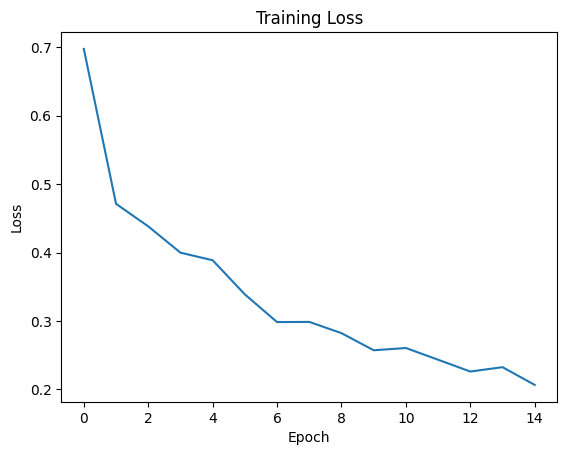

In [16]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

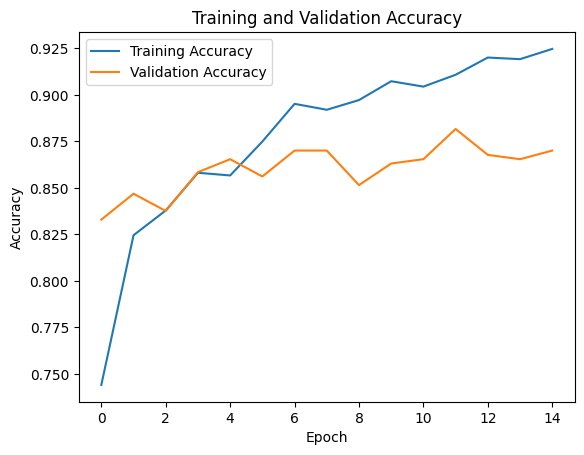

In [17]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [18]:
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
  for images, labels in test_dataset:
    images, labels = images.to(device), labels.to(device)
    y_eval = model(images)
    _, predicted = torch.max(y_eval, 1)
    correct_test += (predicted==labels).sum().item()  # .item() converts tensor value to single value scalar
    total_test += len(labels)
  test_accuracy = correct_test/total_test

print(f"Overall test Accuracy: {test_accuracy:.4f}")
print(f"Final train Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final validation Accuracy: {validation_accuracy[-1]:.4f}")

Overall test Accuracy: 0.8542
Final train Accuracy: 0.9247
Final validation Accuracy: 0.8701


In [27]:
import gc
del model, optimizer, criterion, images, labels, outputs
gc.collect()
torch.cuda.empty_cache()

We can clearly see a significant improvement in accuracy after fine-tuning MobileNet. While a simple deep neural network approach was struggling to reach meaningful performance, fine-tuning gives us a substantial jump in both training and validation metrics. The training accuracy reaches nearly 98.8%, indicating that the model is fitting the training data extremely well.

At the same time, the validation accuracy is around 94.2%, and the overall test accuracy is 91.9%, which shows strong generalization to unseen data. This gap between training and validation/test accuracy is reasonable, reflecting a little overfitting but still very solid performance.

The results demonstrate the power of fine-tuning pretrained networks: the pretrained MobileNet features adapt efficiently to our specific task without needing to train from scratch, and careful learning rate management ensures the model learns effectively without catastrophic forgetting. Overall, the performance boost is substantial and highlights the effectiveness of transfer learning in this scenario.